<a href="https://colab.research.google.com/github/Daywalker21/Test/blob/master/TransferLearning_MPA9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## TRANSFER LEARNING FOR COMPUTER VISION TUTORIAL
In this tutorial, you will learn how to train a convolutional neural network for image classification using transfer learning.


In [0]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import torch
from torch import nn
from torch import optim

import torchvision
from torchvision import datasets, models, transforms

In [0]:
# setting seed for reproducibility
def seed_everything(seed):
    import random
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(42)

### Dataset

In this demonstration, we will be using [CIFAR 10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset. It is very famous tiny images dataset collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton.

The CIFAR-10 dataset consists of **60000 32x32 colour images in 10 classes**, with **6000 images per class**. There are **50000 training images and 10000 test images**.

The 10 different classes represent **airplanes, automobile, birds, cats, deer, dogs, frogs, horses, ships, and trucks.**

![10 random images from each classes](https://pytorch.org/tutorials/_images/cifar10.png)

In [0]:
# transforms to be applied on Training Dataset 
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    # Always double check what values you're using to Normalize your data with,
    # using stats of ImageNet in this case will make your model perform worse.
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)), 
])

# transforms to be applied on Training Dataset
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
])

Data loading in PyTorch can be separated in 2 parts:
* Data must be wrapped on a [Dataset](https://pytorch.org/docs/master/data.html#torch.utils.data.Dataset) parent class where the methods $__getitem__$ and $__len__$ must be overrided. Not that at this point the data is not loaded on memory. PyTorch will only load what is needed to the memory.
* Use a [Dataloader](https://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) that will actually read the data and put into memory.

Since, CIFAR10 is a fairly common dataset, we are given direct method to use it.

In [0]:
# https://pytorch.org/docs/stable/torchvision/datasets.html#torchvision.datasets.CIFAR10
train_dataset = torchvision.datasets.CIFAR10(root='data', train=True, download=True,
                                             transform=transform_train)

# Dataloader combines a dataset and a sampler, and provides an iterable 
# over the given dataset.
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128,
                                               shuffle=True, num_workers=4)

Files already downloaded and verified


In [0]:
test_dataset = torchvision.datasets.CIFAR10(root='data', train=False, download=True,
                                            transform=transform_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=128,
                                               shuffle=False, num_workers=4)

Files already downloaded and verified


In [0]:
classes = ('plane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

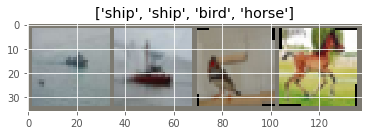

In [0]:
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#visualize-a-few-images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.247, 0.243, 0.261])
    inp = std * inp + mean #unnomalize
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


# get some training images
inputs, labels = next(iter(train_dataloader))
out = torchvision.utils.make_grid(inputs[:4])
imshow(out, title=[classes[x] for x in labels[:4]])

## Finetuning the convnet

Instead of random initializaion, we initialize the network with a pretrained network, like the one that is trained on imagenet dataset. Rest of the training looks as usual.

Load a pretrained model and reset final fully connected layer or final blocks of the pretrained model.

Select anyone of the available models from [here](https://pytorch.org/docs/stable/torchvision/models.html) with a reasonable accuracy on the Imagenet for the task on hand.

We will be using Resnet18 for our demonstration.

In [0]:
model = torchvision.models.resnet18(pretrained=True)
in_feature = model.fc.in_features
model

In [0]:
model.fc = nn.Sequential(nn.Linear(in_feature, 128), nn.ReLU(), nn.Linear(128, 10))#nn.Linear(in_feature, 10) # 
model

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

n_epoch = 10

In [0]:
train_accuracy = []
test_accuracy = []

train_losses = []
test_losses = []

for epoch in range(n_epoch):
    start = time.time()
    print('-'*50)
    print('Epoch {}/{}'.format(epoch + 1, n_epoch))
    train_loss = 0.
    test_loss = 0.
    
    train_correct = 0
    test_correct = 0

    for data, targets in train_dataloader:
        model.train()
        data, targets = data.to(device), targets.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(output, 1)
        train_correct += (predicted.eq(targets)).sum().item()

    train_loss /= len(train_dataloader)
    train_losses.append(train_loss)
    train_correct /= len(train_dataloader.dataset)
    train_accuracy.append(train_correct)

    print("Train Loss : {}, Train Accuracy :{}".format(train_loss, train_correct))

    with torch.no_grad():
        for data, targets in test_dataloader:
            # print(data.shape, targets.shape)
            data, targets = data.to(device), targets.to(device)
            output = model(data)
            loss = criterion(output, targets)
            test_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            test_correct += (predicted.eq(targets)).sum().item()

    test_loss /= len(test_dataloader)
    test_losses.append(test_loss)
    test_correct /= len(test_dataloader.dataset)
    test_accuracy.append(test_correct)

    print("Test Loss : {}, Test Accuracy :{}".format(test_loss, test_correct))
    print("Time : {:.5f}sec".format(time.time()-start))

--------------------------------------------------
Epoch 1/10
Train Loss : 0.9981875463824748, Train Accuracy :0.65484
Test Loss : 0.7143335463125494, Test Accuracy :0.7575
Time : 21.18492sec
--------------------------------------------------
Epoch 2/10
Train Loss : 0.674243988588338, Train Accuracy :0.77028
Test Loss : 0.6269290096397642, Test Accuracy :0.7936
Time : 21.35216sec
--------------------------------------------------
Epoch 3/10
Train Loss : 0.5806859172213718, Train Accuracy :0.80166
Test Loss : 0.5922694602344609, Test Accuracy :0.8023
Time : 21.34386sec
--------------------------------------------------
Epoch 4/10
Train Loss : 0.5217893064936714, Train Accuracy :0.82016
Test Loss : 0.5782845307000076, Test Accuracy :0.8101
Time : 21.23497sec
--------------------------------------------------
Epoch 5/10
Train Loss : 0.47987646855356747, Train Accuracy :0.83408
Test Loss : 0.5550508091721353, Test Accuracy :0.8197
Time : 21.63899sec
----------------------------------------

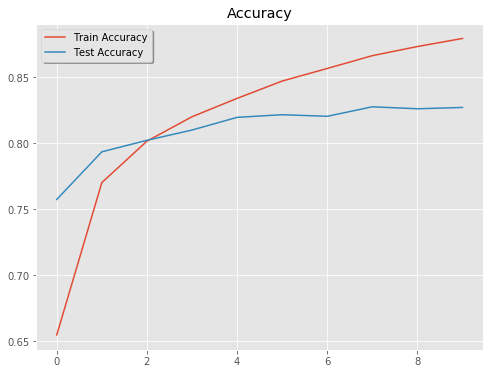

In [0]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(range(n_epoch), train_accuracy, label='Train Accuracy')
ax.plot(range(n_epoch), test_accuracy, label='Test Accuracy')
ax.legend(loc="upper left", shadow=True)
ax.set_title("Accuracy");

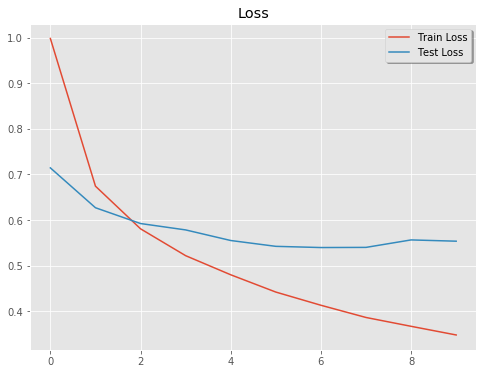

In [0]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(range(n_epoch),train_losses, label='Train Loss')
ax.plot(range(n_epoch), test_losses, label='Test Loss')
ax.legend(loc="upper right", shadow=True)
ax.set_title("Loss");

### Visualizing some predictions

In [0]:
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#visualizing-the-model-predictions
def visualize_predictions(model, num_images=6):
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for data, targets in test_dataloader:
            data, targets = data.to(device), targets.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(classes[predicted[j]]))
                imshow(data.cpu()[j])

                if(images_so_far == num_images):
                    return

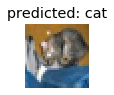

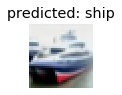

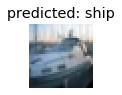

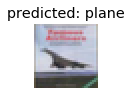

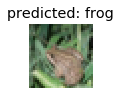

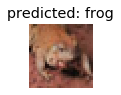

In [0]:
visualize_predictions(model)

In [0]:
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: {}%'.format(100 * correct / total))

Accuracy of the network on the 10000 test images: 83.46%
